In [ ]:
# Adapted from
# https://github.com/salvadorgarciamunoz/kipet/blob/master/kipet/examples/Ex_12_multexp_conc_diffreact.py
#

In [1]:
from kipet import KipetModel
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

    Set objects from pyomo.core.base.set or pyomo.core.  (deprecated in 5.7)
    (called from <frozen importlib._bootstrap>:219)
_SetProduct not found


In [6]:
def rxn_model(kipet_model, label, cinit, cvars, timespan):

    r1 = kipet_model.new_reaction(label)

    r1.add_component('A', state = 'concentration', init = cinit['A'])
    r1.add_component('B', state = 'concentration', init = cinit['B'])
    r1.add_component('C', state = 'concentration', init = cinit['C'])
    r1.add_component('D', state = 'concentration', init = cinit['D'])

    r1.add_parameter('k1', init = 0.1, bounds = (0.0, 10.0))
    r1.add_parameter('k2', init = 0.1, bounds = (0.0, 10.0))

    def rule_odes(m,t):
        exprs = dict()
        exprs['A'] = -m.P['k1']*m.Z[t,'A']*m.Z[t,'B']
        exprs['B'] = -m.P['k1']*m.Z[t,'A']*m.Z[t,'B']-m.P['k2']*m.Z[t,'B']*m.Z[t,'C']
        exprs['C'] = m.P['k1']*m.Z[t,'A']*m.Z[t,'B']-m.P['k2']*m.Z[t,'B']*m.Z[t,'C']
        exprs['D'] = m.P['k2']*m.Z[t,'B']*m.Z[t,'C']
        return exprs

    r1.add_equations(rule_odes)
    
    r1.variances = cvars
    r1.set_times(timespan[0], timespan[1])
    r1.settings.solver.linear_solver = 'ma27'
    
    return r1

In [7]:
datainfo = {'Exp1': {'init': {'A': 1, 'B': 2, 'C': 0, 'D': 0}, 'cvar': {'A': 1, 'B':1, 'C': 1, 'D': 1},
                     'timespan': (0, 4.0)},
            'Exp2': {'init': {'A': 1, 'B': 1, 'C': 0, 'D': 0}, 'cvar': {'A': 1, 'B':1, 'C': 1, 'D': 1},
                     'timespan': (0, 7.0)}}

In [25]:
kipet_model = KipetModel()
r1 = rxn_model(kipet_model, 'rxn1', datainfo['Exp1']['init'], datainfo['Exp1']['cvar'], datainfo['Exp1']['timespan'])
r2 = rxn_model(kipet_model, 'rxn2', datainfo['Exp2']['init'], datainfo['Exp2']['cvar'], datainfo['Exp2']['timespan'])

In [26]:
dirname = '/home/paperspace/learn_kipet/my_data_sets/'
C_data_1 = pd.read_csv(dirname + 'ABCD_cb0_2.csv', index_col = 0)
C_data_2 = pd.read_csv(dirname + 'ABCD_cb0_1.csv', index_col = 0)

In [27]:
r1.add_dataset('C_data_1', category = 'concentration', data = C_data_1[['A', 'C']])
r2.add_dataset('C_data_2', category = 'concentration', data = C_data_2[['B', 'D']])

In [28]:
kipet_model.settings.solver.linear_solver = 'ma27'

In [29]:
kipet_model.run_opt()

times are: <class 'tuple'>
Warning! Since Cm-matrix contains negative values Kipet is assuming a derivative of Cm has been inputted
times are: <class 'tuple'>
times are: <class 'tuple'>
0 4.0
    we will be changing that default to 'Reals' in the future.  If you really
    intend the domain of this Param (sigma) to be 'Any', you can suppress this
    warning by explicitly specifying 'within=Any' to the Param constructor.
    (deprecated in 5.6.9, will be removed in 6.0) (called from
    /home/paperspace/my_pyenvs/kipetenv/lib/python3.7/site-
    packages/Pyomo-5.7.1-py3.7-linux-x86_64.egg/pyomo/core/base/param.py:640)
    we will be changing that default to 'Reals' in the future.  If you really
    intend the domain of this Param (sigma) to be 'Any', you can suppress this
    warning by explicitly specifying 'within=Any' to the Param constructor.
    (deprecated in 5.6.9, will be removed in 6.0) (called from
    /home/paperspace/my_pyenvs/kipetenv/lib/python3.7/site-
    packages/Pyomo

Constraint violation....:   5.3881343831108097e-12    5.3881343831108097e-12
Complementarity.........:   2.5147258251598824e-09    2.5147258251598824e-09
Overall NLP error.......:   2.5147258251598824e-09    2.5147258251598824e-09


Number of objective function evaluations             = 11
Number of objective gradient evaluations             = 11
Number of equality constraint evaluations            = 11
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 11
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 10
Total CPU secs in IPOPT (w/o function evaluations)   =      0.052
Total CPU secs in NLP function evaluations           =      0.000

EXIT: Optimal Solution Found.

SOLVING PARAMETER ESTIMATION FOR MULTIPLE DATASETS

Fixed parameters are:  set()


In [30]:
print("The estimated parameters are:")

for model, results in kipet_model.results.items():
     results.show_parameters

The estimated parameters are:

The estimated parameters are:
k1 1.072393996358529
k2 1.8492305637580626

The estimated parameters are:
k1 1.072393996358529
k2 1.8492305637580626


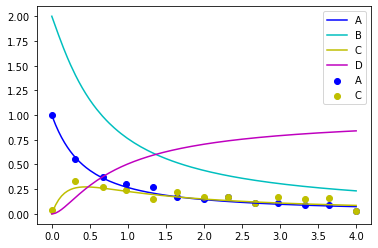

In [33]:
colors = ['b', 'c', 'y', 'm', 'r']
cmps = ['A', 'B', 'C', 'D']

expt = 'rxn1'
fig, ax = plt.subplots()
for i, x in enumerate(cmps):
    if x in kipet_model.results[expt].Cm.columns:
        ax.scatter(kipet_model.results[expt].Cm.index, kipet_model.results[expt].Cm[x], label = x, color = colors[i])
    ax.plot(kipet_model.results[expt].Z.index, kipet_model.results[expt].Z[x], label = x, color = colors[i])
ax.legend()

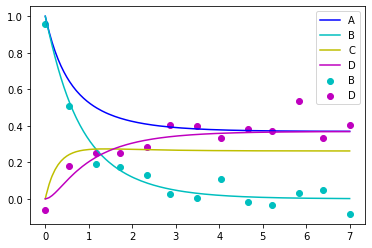

In [34]:
expt = 'rxn2'
fig, ax = plt.subplots()
for i, x in enumerate(cmps):
    if x in kipet_model.results[expt].Cm.columns:
        ax.scatter(kipet_model.results[expt].Cm.index, kipet_model.results[expt].Cm[x], label = x, color = colors[i])
    ax.plot(kipet_model.results[expt].Z.index, kipet_model.results[expt].Z[x], label = x, color = colors[i])
ax.legend()